# This is the fifth and last step in project.

Motivaton: To train RxG model.

Final output: Accuracy xG shift of improvised model.

In [16]:
# import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from matplotlib import pyplot as plt
import json
from numpyencoder import NumpyEncoder
from tqdm import tqdm
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None

In [2]:
# file path
ROOT = os.path.join(os.getcwd(), 'Statsbomb_data\open-data-master')
DATA = os.path.join(ROOT, 'data')
FINAL_DF = os.path.join(ROOT,'final_dataframes')

# Preparing Data

In [3]:
''' Loading data used to train improvised model.

Variables:-
FINAL_DF - string - file path to all pickle files
'''
df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'engineered_features.pkl')
)

In [5]:
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

In [6]:
''' Loading baseline data used to train baseline model.

Variables:-
FINAL_DF - string - file path to all pickle files
'''
main_baseline_df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'final_df.pkl')
)

In [7]:
''' Fetch top 10,000 xG value rows. This data will be used to train RxG model.

Variables:-
main_baseline_df - DataFrame - data with baseline features
'''
baseline_df = main_baseline_df.sort_values(by=['statsbomb_xg']).tail(10000)

In [8]:
''' Fetch remaining data. This data will be used to test the performance.

Variables:-
main_baseline_df - DataFrame - data with baseline features
'''
other_baseline_df = main_baseline_df.sort_values(by=['statsbomb_xg']).head(main_baseline_df.shape[0]-10000)

In [9]:
''' Joining dataframe with improvised features with main baseline and other baseline data.

Variables - 
baseline_df - DataFrame - Top 10,000 xG data with baseline features
other_baseline_df - DataFrame - remaining baseline data for testing RxG model
df - DataFrame - data with improvised features
'''
final_df = baseline_df.join(
    other=df[['player_name','body_part_strong','wpa','dfg','angle','gk_distance','specific_position']],
    how='left'
)
other_final_df = other_baseline_df.join(
    other=df[['player_name','body_part_strong','wpa','dfg','angle','gk_distance','specific_position']],
    how='left'
)

In [10]:
final_df.drop(['player','player_name','event_id'],axis=1,inplace=True)
other_final_df.drop(['player','player_name','event_id'],axis=1,inplace=True)

In [12]:
final_df.head(5)

,first_touch,open_goal,under_pressure,shot_technique,shot_body_part,statsbomb_xg,goal,aerial_shot,from_play,one_v_one,body_part_strong,wpa,dfg,angle,gk_distance,specific_position
16726,False,False,True,Normal,Head,0.064161,False,True,Corner,False,NaN,False,0.153869,0.142320,0.035391,Midfield
1835,False,False,False,Normal,Head,0.064173,False,True,Free Kick,False,Right Foot,False,0.137108,0.210996,0.016094,Attack
10763,False,False,True,Normal,Head,0.064179,False,True,Regular Play,False,Right Foot,False,0.235676,0.104622,0.097355,Attack
21030,False,False,False,Normal,Left Foot,0.064184,False,True,Free Kick,False,NaN,False,0.281548,0.052109,0.047514,Defense
720,False,False,False,Normal,Right Foot,0.064192,False,True,Regular Play,False,Left Foot,False,0.242280,0.112794,0.035031,Midfield


In [13]:
''' Encoding binary categories of dataframes.

Variables:-
final_df - DataFrame - Top 10,000 xG data with baseline and improvised features
other_final_df - DataFrame - remaining baseline and improvised data for testing RxG model
'''
encoded_final_df = pd.get_dummies(
    data=final_df,
    columns=['first_touch','open_goal','under_pressure','shot_technique','shot_body_part','goal','aerial_shot','from_play','one_v_one','wpa'],
    drop_first=True
)
encoded_other_final_df = pd.get_dummies(
    data=other_final_df,
    columns=['first_touch','open_goal','under_pressure','shot_technique','shot_body_part','goal','aerial_shot','from_play','one_v_one','wpa'],
    drop_first=True
)

In [14]:
''' Encoding other categorical features

Variables:-
encoded_final_df - DataFrame - Top 10,000 xG data with baseline and improvised features with encoding
encoded_other_final_df - DataFrame - remaining baseline and improvised data for testing RxG model with encoding
'''

category_mappings = {}
category_other_mappings = {}
for c in ['body_part_strong','specific_position']:
    encoded_final_df[c]=encoded_final_df[c].astype('category')  
    d = dict(enumerate(encoded_final_df[c].cat.categories))
    category_mappings[c]=d  
    encoded_final_df[c]=encoded_final_df[c].cat.codes
    
    encoded_other_final_df[c]=encoded_other_final_df[c].astype('category')  
    d = dict(enumerate(encoded_other_final_df[c].cat.categories))
    category_other_mappings[c]=d  
    encoded_other_final_df[c]=encoded_other_final_df[c].cat.codes

In [18]:
''' 
    Initiate parameter search space and objective function for hyperparameter tuning.

    Variables:-
    X - DataFrame - dependent variables
    y - Series - target variable
    space - dict - parameter space for tuning
    clf - xgb.XGBClassifier 0bject - XgBoost classifier object
    evaluation - list - evaluation criteria for tuning
    pred - array - test predictions of model
    accuracy - float - classification accuracy score of model

'''

X = encoded_final_df.drop('goal_True',axis=1).reset_index(drop=True)
y = encoded_final_df['goal_True'].reset_index(drop=True)

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.3)



space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train.drop('statsbomb_xg',axis=1), y_train), ( X_test.drop('statsbomb_xg',axis=1), y_test)]
    
    clf.fit(X_train.drop('statsbomb_xg',axis=1), y_train,
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test.drop('statsbomb_xg',axis=1))
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [19]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.758                                                  
SCORE:                                                               
0.758                                                                
SCORE:                                                               
0.758                                                                
SCORE:                                                               
0.758                                                                
SCORE:                                                               
0.758                                                                
SCORE:                                                               
0.758                                                                
SCORE:                                                               
0.758                                                                
SCORE:                                          

In [20]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5488914624196694, 'gamma': 6.399179487754024, 'max_depth': 11.0, 'min_child_weight': 8.0, 'reg_alpha': 144.0, 'reg_lambda': 0.5901615508776861}


# Plotting xG Shift

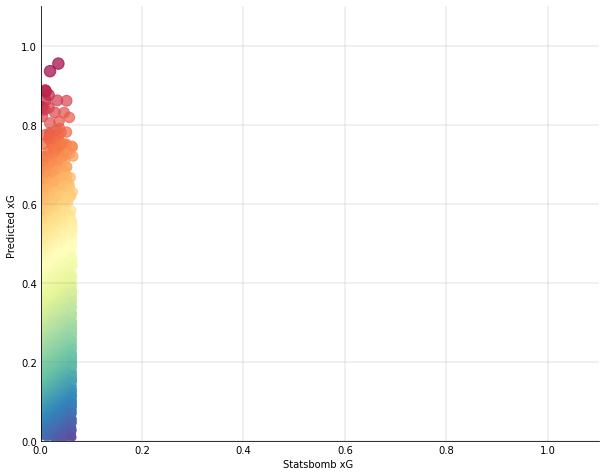

In [24]:
''' Plotting the predicted xG vs statsbomb xG for RxG model

Variables:-
X - DataFrame - dependent features
y - Series - target features
other_xG - array - predicted xG values of remaining data, i.e. the probability of class 1
'''

X = encoded_final_df.drop('goal_True',axis=1).reset_index(drop=True)
y = encoded_final_df['goal_True'].reset_index(drop=True)

model = xgb.XGBClassifier(tree_method="hist")
X_train, X_test, y_train, target_test=train_test_split(X, y, test_size = 0.2)
model.fit(X_train.drop('statsbomb_xg',axis=1), y_train)


other_xG = model.predict_proba(encoded_other_final_df.drop(['statsbomb_xg','goal_True'],axis=1))[:,1]

error = np.subtract(
    encoded_other_final_df['statsbomb_xg'],
    other_xG
)

plt.figure(figsize=(10,8))
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(
    color='gray',
    alpha=0.15,
    linewidth=1.5
)
g=plt.scatter(
    encoded_other_final_df['statsbomb_xg'],
    other_xG,
    s=(plt.rcParams['lines.markersize'] * (1+np.absolute(error))) ** 2,
    c=error,
    alpha=0.7,
    cmap='Spectral'
)
g.axes.set_xlabel('Statsbomb xG ')
g.axes.set_ylabel('Predicted xG ')
g.axes.spines[['right', 'top']].set_visible(False)
g.axes.tick_params(axis=u'both', which=u'both',length=0)

In [29]:
print(f"ROOT MEAN SQUARED ERROR: {metrics.mean_squared_error(y_true=encoded_other_final_df.drop(['goal_True'],axis=1)['statsbomb_xg'], y_pred=other_xG)}")

ROOT MEAN SQUARED ERROR: 0.040158617282408236


### Summary

The RxG models shift all lower xGs to higher, as a result of an inductive bias of high xG data.

The resulting RMSE value represents skewness as the RMSE is more than improvised model.

This model can be used to find players that fit better in this inductive bias, leading to a customized xG model.

Football scouts can leverage this method to create xG models with their requirements.

Now, finding the next Lionel Messi or next Zinedine Zidane won't be that difficult.
